In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbn
import json
import numpy as np
from scipy import stats
import arch.bootstrap

import oenotebook as oenb
from openeye import oequacpac, oechem, oedepict
import qcfractal.interface as ptl

import fragmenter
import cmiles
import qcfractal
import qcportal
print(qcportal.__version__)
print(qcfractal.__version__)
print('fragmenter version: {}'.format(fragmenter.__version__))
print('cmiles version: {}'.format(cmiles.__version__))

v0.7.2
v0.13.0+2.ga1691bfa
fragmenter version: 0.0.4+25.gbb12030.dirty
cmiles version: v0.1.5+1.gdbd63e8


In [3]:
oemols = fragmenter.chemi.file_to_oemols('biphenyls.smi')

In [4]:
bond_maps = []
wbos_dep = []
wbos_ind = []
for mol in oemols:
    cmiles.utils.add_atom_map(mol)
    # Calculate WBO for only one conformation and ELF10 to see if WBOs differ. They should be the same for 
    # biphenlys because there is only one conformer per molecule
    conf_independent = fragmenter.chemi.get_charges(mol, keep_confs=-1)
    for bond in conf_independent.GetBonds():
        if bond.IsRotor():
            map_idx = (bond.GetBgn().GetMapIdx(), bond.GetEnd().GetMapIdx())
            bond_maps.append(map_idx)
            wbos_dep.append(bond.GetData('WibergBondOrder'))
    for i, conf in enumerate(conf_independent.GetConfs()):
        if i > 0:
            print(mol.GetName(), i)
            break
        mol_copy = oechem.OEMol(conf)
        oequacpac.OEAssignPartialCharges(mol_copy, oequacpac.OECharges_AM1BCCSym)
        for bond in mol_copy.GetBonds():
            if bond.IsRotor():
                wbos_ind.append(bond.GetData('WibergBondOrder'))


In [5]:
if wbos_dep == wbos_ind:
    print('Same WBOs for ELF10 and single conformer')

Same WBOs for ELF10 and single conformer


In [6]:
colors = fragmenter.chemi._KELLYS_COLORS

In [7]:
def visualize_biphenyls(mols, fname, rows, cols, bond_idx, wbos):
    image = oedepict.OEImage(400, 200)
    grid = oedepict.OEImageGrid(image, rows, cols)
    opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                      oedepict.OEScale_AutoScale)
    minscale = float("inf")
    for m in mols:
        #mol = oechem.OEMol()
        #oechem.OESmilesToMol(mol, s)
        #mols.append(mol)
        oedepict.OEPrepareDepiction(m, False, True)
        minscale = min(minscale, oedepict.OEGetMoleculeScale(m, opts))
    
    opts.SetScale(minscale)
    for i, m in enumerate(zip(mols, grid.GetCells())):
        mol = m[0]
        cell = m[1]
        mol.SetTitle(' ')
        oedepict.OEPrepareDepiction(mol)
        
        bond = get_bond(mol, bond_idx[i])
        atom_bond_set = oechem.OEAtomBondSet()
        atom_bond_set.AddAtoms([bond.GetBgn(), bond.GetEnd()])
        atom_bond_set.AddBond(bond)
            
        hstyle = oedepict.OEHighlightStyle_BallAndStick
        hcolor = oechem.OEColor(colors[i])
        
        disp = oedepict.OE2DMolDisplay(mol, opts)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set) 

        bond_label = oedepict.OEHighlightLabel("{:.2f}".format((wbos[i])), hcolor)
        bond_label.SetFontScale(4.0)
        oedepict.OEAddLabel(disp, bond_label, atom_bond_set)
        oedepict.OERenderMolecule(cell, disp)
    
    oedepict.OEWriteImage(fname, image)
    
def get_bond(mol, bond_idx):
    atom_bond_set = oechem.OEAtomBondSet()
    atoms = [mol.GetAtom(oechem.OEHasMapIdx(i)) for i in bond_idx]
    bond = mol.GetBond(atoms[0], atoms[1])
    return bond
    

In [8]:
visualize_biphenyls(oemols[1:5], 'biphenyls_wbos.pdf', rows=1, cols=4, bond_idx=bond_maps[1:5], wbos=wbos_ind[1:5])
visualize_biphenyls(oemols[6:10], 'biphenyls_fluoro_wbos.pdf', rows=1, cols=4, bond_idx=bond_maps[6:10], wbos=wbos_ind[6:10])

In [9]:
# Visualize torsion scans
client = ptl.FractalClient()
phenyl_dataset = client.get_collection('TorsionDriveDataset', 'OpenFF Substituted Phenyl Set 1')
with open('qca-submission/biphenyls_set_input.json', 'r') as f:
    job_indices = list(json.load(f).keys())
fluoro_phenyls = [i for i in job_indices if 'F' in i]
phenyls = [i for i in job_indices if 'F' not in i]

phenyl_dataset.visualize(fluoro_phenyls, specs='default', units='kJ/mol')
phenyl_dataset.visualize(phenyls, specs='default', units='kJ/mol')

In [10]:
# Get energies
def get_energies(dataset, indices):
    angles = np.arange(-165, 195, 15)
    energies = []
    wbos = []
    for index in indices:
        print(index)
        entry = dataset.get_entry(index)
        mapped_smiles = entry.attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles']
        mol = oechem.OEMol()
        oechem.OESmilesToMol(mol, mapped_smiles)
        n_atoms = mol.GetMaxAtomIdx()
        td = dataset.get_record(index, specification='default')
        dih = td.keywords.dihedrals[0]
        final_energies =[td.get_final_energies(int(i))*fragmenter.utils.HARTREE_2_KJMOL for i in angles]
        final_energies.insert(0, final_energies[-1])
        final_energies = np.asarray(final_energies) - min(final_energies)
        wbo = []
        for angle in angles:
            opt = td.get_history(int(angle))[-1].get_trajectory()[-1]
            wiberg = np.array(opt.extras['qcvars']['WIBERG_LOWDIN_INDICES']).reshape(-1, n_atoms)
            wbo.append(wiberg[dih[1]][dih[2]])
        wbos.append(wbo)
        energies.append(final_energies)
    return energies, wbos

biphenyls_sorted = [phenyls[2], phenyls[0], phenyls[3], phenyls[1]]
biphenyls_flouro_sorted = [fluoro_phenyls[1], fluoro_phenyls[0], fluoro_phenyls[3], fluoro_phenyls[2]]
angles = np.arange(-165, 195, 15)

biphenyls_sorted_energies, bipheny_sorted_wbos = get_energies(phenyl_dataset, biphenyls_sorted)
biphenyls_flouro_sorted_energies, biphenyls_flouro_sorted_wbos = get_energies(phenyl_dataset, biphenyls_flouro_sorted)


[cH:1]1cc(cc[c:2]1[c:3]2[cH:4]cncc2)O
[cH:1]1cc(cc[c:2]1[c:3]2[cH:4]c[nH+]cc2)O
[cH:1]1cc(cc[c:2]1[c:3]2[cH:4]cncc2)[O-]
[cH:1]1cc(cc[c:2]1[c:3]2[cH:4]c[nH+]cc2)[O-]
c1[cH:1][c:2](c(cc1O)F)[c:4]2[cH:3]cncc2
c1[cH:1][c:2](c(cc1O)F)[c:4]2[cH:3]c[nH+]cc2
c1[cH:1][c:2](c(cc1[O-])F)[c:4]2[cH:3]cncc2
c1[cH:1][c:2](c(cc1[O-])F)[c:4]2[cH:3]c[nH+]cc2


In [11]:
def visualize_td(energies, fname):
    angles = np.arange(-180, 195, 15)
    plt.figure()
    for i, energy in enumerate(energies):
        plt.plot(angles, energy, color=colors[i])
        plt.plot(angles, energy, '.', color=colors[i])
    plt.xlabel('Torsion angles (degree)', fontsize=14)
    plt.ylabel('Relative energy (kJ/mol)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')

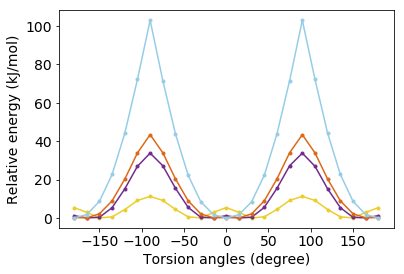

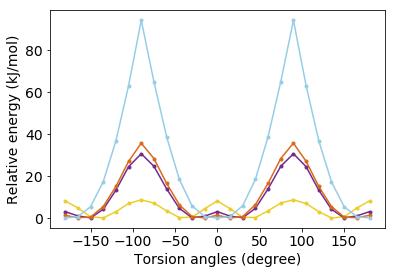

In [12]:
visualize_td(biphenyls_sorted_energies, 'biphenyls_torstion_scan.pdf')
visualize_td(biphenyls_flouro_sorted_energies, 'biphenyls_fluoro_torsion_scan.pdf')

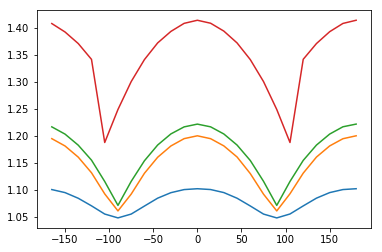

In [13]:
for i in bipheny_sorted_wbos:
    plt.plot(angles, i)

In [14]:
# Fit line to wbo and max energies and visualize 
def compute_r_ci(wbos, max_energies):
    return (stats.linregress(wbos, max_energies)[2])**2

def visualize_wbo_correlation(energies, wbos, fname):
    colors = fragmenter.chemi._KELLYS_COLORS
    fig, ax = plt.subplots()
    max_energies = [max(e) for e in energies]
    slope, intercept, r_value, p_value, std_err = stats.linregress(wbos, max_energies)
    ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(wbos), np.asarray(max_energies)).conf_int(compute_r_ci, 1000)
    CI_95 = 1.96*std_err
    plt.plot(np.unique(wbos), np.poly1d([slope, intercept])(np.unique(wbos)), 'black')
    for i, (wbo, en) in enumerate(zip(wbos, max_energies)):
        plt.scatter(wbo, en, c=colors[i], linewidths=5)
    textstr = '\n'.join((
        r'slope=%.2f$_{%.2f}^{%.2f}$' % (slope, slope-CI_95, slope+CI_95),
        r'$r^2=%.2f_{%.2f}^{%.2f}$' % (r_value**2, ci_r_value[0], ci_r_value[1])))
        #r'P value=%.3f' % (p_value, ),
        #r'standard error=%.2f' % (std_err, )))
    props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props);
    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight');

/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning:

invalid value encountered in double_scalars

/Users/sternc1/anaconda3/envs/qcf/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning:

invalid value encountered in double_scalars



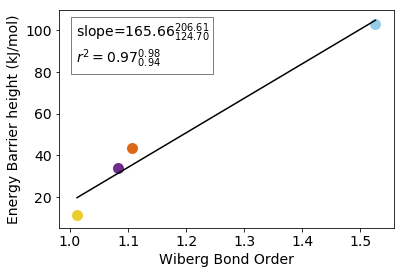

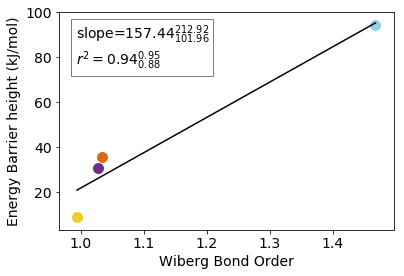

In [15]:
visualize_wbo_correlation(biphenyls_sorted_energies, wbos_dep[1:5], 'biphenyl_energy_vs_wbo.pdf')
visualize_wbo_correlation(biphenyls_flouro_sorted_energies, wbos_dep[6:10], 'biphenyl_flouro_energy_vs_wbo.pdf')